In [525]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib
import matplotlib.lines as mlines
import pickle as pk

In [542]:
dataset = 'cifar10'

if dataset == 'cifar10':
    model = 't2t_7'
    point_1_ic = 10
    point_2_ic = 12
    total_mudaa = 13.4
    end_acc = 94.5
    lambda_val_1 = 0.1
    lambda_val_2 = 1.5
    L=7
elif dataset == 'cifar100':
    model = 't2t_14'
    total_mudaa = 56
    end_acc = 88.4
    L=14
elif dataset == 'svhn':
    L=14
    min_ic = 0
    model = 't2t_7'
    max_ic = 100
    total_mudaa = 13.4
    end_acc = 91

In [543]:
with open(dataset+'_'+model+'/'+dataset+'_boosted_results.pk', 'rb') as file:
        list_dict_boosted = pk.load(file)
        
with open(dataset+'_'+model+'/'+dataset+'_weighted_results.pk', 'rb') as file:
        list_dict_weighted = pk.load(file)
        

In [544]:
path = dataset+'_'+model+'/'
list_files = os.listdir(path)

list_dicts_ours = []
for file_name in list_files:
   
    if '.pk' in file_name and 'boosted' not in file_name and 'weighted' not in file_name:
        lambda_val = float(file_name.split('_')[-2])
        
        with open(os.path.join(path, file_name), 'rb') as file:
            dicts = pk.load(file)
        dicts['lambda'] = lambda_val
        list_dicts_ours.append(dicts)
        print(lambda_val)
        if lambda_val == lambda_val_1:
            our_point_to_display = dicts
        if lambda_val == lambda_val_2:
            our_point2_to_display = dicts

0.7
0.01
0.1
0.9
0.8
1.5
0.05
1.0
0.6
0.5
0.15


In [545]:
def extract_metrics_we_want(metrics_dict, keys_we_want):
    metrics_we_want = {}
    for key, val in metrics_dict.items():
        if key in keys_we_want:
            metrics_we_want[key] = val
    return metrics_we_want

def get_all_cov_C(metrics):
    cov_keys_dict = {}
    C_keys_dict = {}
    for key in metrics.keys():
        if 'cov' in key:
            tokens = key.split('cov')
            alpha = tokens[1]
            prefix = tokens[0]
            
            cov_key = prefix+'cov'+alpha
            C_key = prefix+'C'+alpha
            if prefix in cov_keys_dict:
                cov_keys_dict[prefix].append(cov_key)
                C_keys_dict[prefix].append(C_key)
            else:
                cov_keys_dict[prefix] = [cov_key] 
                C_keys_dict[prefix] = [C_key]  
    return cov_keys_dict, C_keys_dict

def get_all_key_with(metrics, substring):
    keys_with_substring = []
    for key in metrics.keys():
        if substring in key:
            keys_with_substring.append(key)
    return keys_with_substring

def find_highest_cov(metrics_we_care_about, cov_keys, requested_alpha):
    alpha_max = 0
    for cov_key in cov_keys:
        
           
            alpha_val = float(cov_key.split('_')[-1])
            emp_cov = metrics_we_care_about['average'+cov_key]

            if 1-emp_cov< requested_alpha:
                if alpha_max < alpha_val:
                    alpha_max = alpha_val
                    #print('switching fot', alpha_val)
    #print('highest alpha is ', alpha_max, 'with emp cov', )
    return alpha_max
            
        

In [546]:
our_df = pd.DataFrame()
keys_we_want = ['test/acc_exit','test/total_cost', 'test/gated_acc', 'test/gated_ece', 'test/gated_ece']
cov_keys_dict, C_keys_dict = get_all_cov_C(list_dicts_ours[0])
type_of_conf = 'test/'
cov_keys = cov_keys_dict[type_of_conf]
C_keys = C_keys_dict[type_of_conf]
cov_keys_baseline = [c.split('test/')[-1] for c in cov_keys] # dumb storing thing, have to remove the test/ fo rhte baseline
C_keys_baseline = [c.split('test/')[-1] for c in C_keys] 


keys_we_want = keys_we_want + cov_keys + C_keys
keys_gated_accs = get_all_key_with(list_dicts_ours[-1], 'gated_acc_')
keys_all_acc = get_all_key_with(list_dicts_ours[-1], 'test/acc')
keys_we_want = keys_we_want



In [547]:
cov_keys_baseline

['cov_0.01',
 'cov_0.015',
 'cov_0.02',
 'cov_0.025',
 'cov_0.03',
 'cov_0.035',
 'cov_0.04',
 'cov_0.045',
 'cov_0.05']

In [548]:
requested_alpha = 0.05

In [549]:
our_df = pd.DataFrame()
for metrics in list_dicts_ours:
    
    metrics_we_care_about = extract_metrics_we_want(metrics, keys_we_want)
    metrics_we_care_about['average_IC'] = np.mean(metrics_we_care_about['test/total_cost'])
    metrics_we_care_about['average_ACC'] = np.mean(metrics_we_care_about['test/gated_acc'])

    for cov_key in cov_keys:
        metrics_we_care_about['average'+cov_key] = np.mean(metrics_we_care_about[cov_key])
        metrics_we_care_about['alpha'+cov_key] = float(cov_key.split('_')[-1]) 
    for C_key in C_keys:
        metrics_we_care_about['average'+C_key] = np.mean(metrics_we_care_about[C_key])
    
    alpha_max = find_highest_cov(metrics_we_care_about, cov_keys, requested_alpha)
  
    if alpha_max >0 :
        C_key = 'test/C_'+str(alpha_max)
        metrics_we_care_about['C'] = metrics_we_care_about[C_key]
        metrics_we_care_about['emp_alpha'] = alpha_max
    
    df = pd.DataFrame(data=metrics_we_care_about)
    
    our_df = pd.concat([df, our_df],axis=0, ignore_index=True)
    
our_point_ic  = np.mean(our_point_to_display['test/total_cost'])
our_point_acc  = np.mean(our_point_to_display['test/gated_acc'])
our_point2_ic = np.mean(our_point2_to_display['test/total_cost'])
our_point2_acc  = np.mean(our_point2_to_display['test/gated_acc'])

In [550]:
def replace_if_closer(points,closest_to_points, val, this_point):
    for i, point in enumerate(points):
        dif_now = np.abs(val-point)
        dif_prev = closest_to_points[i][1]
        if dif_now< dif_prev:
            closest_to_points[i] = (this_point, dif_now)
    return closest_to_points
def collect_baseline_data(list_dict_baseline, points):
    baseline_df = pd.DataFrame()
    closest_to_points = [(None, 100) for _ in points]
    for metrics in list_dict_baseline:
        metrics['average_IC'] = np.mean(metrics['EXPECTED_FLOPS'])
        metrics['average_ACC'] = np.mean(metrics['ACC'])
        ic = np.mean(metrics['EXPECTED_FLOPS'])
        
        closest_to_points = replace_if_closer(points,closest_to_points, ic, metrics)
        for cov_key in cov_keys_baseline:
            metrics['average'+cov_key] = np.mean(metrics[cov_key])/100.0
            metrics['alpha'+cov_key] = float(cov_key.split('_')[-1])
        for C_key in C_keys_baseline:
            metrics['average'+C_key] = np.mean(metrics[C_key])

        alpha_max = find_highest_cov(metrics, cov_keys_baseline, requested_alpha)
        
        if alpha_max >0 :
            C_key = 'C_'+str(alpha_max)
            metrics['C'] = metrics[C_key]
            metrics['emp_alpha'] = alpha_max
        df = pd.DataFrame(data=metrics)
        baseline_df = pd.concat([df, baseline_df],axis=0, ignore_index=True)
    return baseline_df, [tuple_points[0] for tuple_points in closest_to_points]


boosted_df, boosted_points = collect_baseline_data(list_dict_boosted, [our_point_ic, our_point2_ic])
weighted_df, weighted_points = collect_baseline_data(list_dict_weighted, [our_point_ic, our_point2_ic])

In [551]:
filtered_boosted_df = boosted_df[boosted_df['average_ACC'].between(end_acc*0.6, end_acc)]
filtered_our_df = our_df[our_df['average_ACC'].between(end_acc*0.6, end_acc)]
filtered_weighted_df = weighted_df[weighted_df['average_ACC'].between(end_acc*0.6, end_acc)]


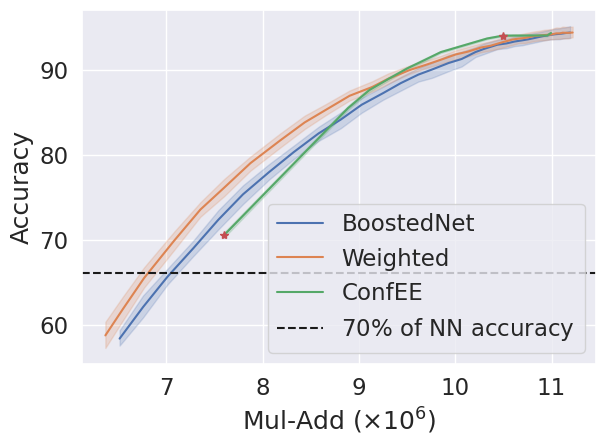

In [552]:
sns.set(font_scale=1.5) 

#print(filtered_our_df)
sns.lineplot(data=filtered_boosted_df, x="average_IC", y="ACC", label="BoostedNet")
sns.lineplot(data=filtered_weighted_df, x="average_IC", y="ACC", label="Weighted")
sns.lineplot(data=filtered_our_df, x="average_IC", y="test/gated_acc", label="ConfEE")
plt.plot([our_point_ic, our_point2_ic], [our_point_acc, our_point2_acc], marker='*', ls='none', ms=6)

# sns.scatterplot(data=filtered_boosted_df, x="average_IC", y="ACC", label="BoostedNet")
# sns.scatterplot(data=filtered_weighted_df, x="average_IC", y="ACC", label="Weighted")
# sns.scatterplot(data=filtered_our_df, x="average_IC", y="test/gated_acc", label="ConfEE")
plt.axhline(y=end_acc*0.7, color='k',linestyle='--', label=r'$70\%$ of NN accuracy')
plt.legend()
plt.xlabel(r'Mul-Add ($\times 10^6$)')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('perf_cost_'+dataset+'.pdf')

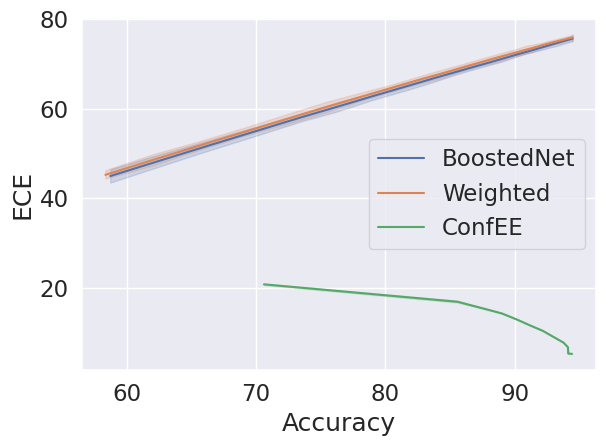

In [553]:
sns.set(font_scale=1.5)  # crazy big
sns.lineplot(data=filtered_weighted_df, x="average_ACC", y="ECE", label="BoostedNet")
sns.lineplot(data=filtered_boosted_df, x="average_ACC", y="ECE", label="Weighted")

sns.lineplot(data=filtered_our_df, x="average_ACC", y="test/gated_ece", label="ConfEE")
plt.xlabel('Accuracy')
plt.ylabel('ECE')
plt.tight_layout()
plt.savefig('perf_ece_'+dataset+'.pdf')

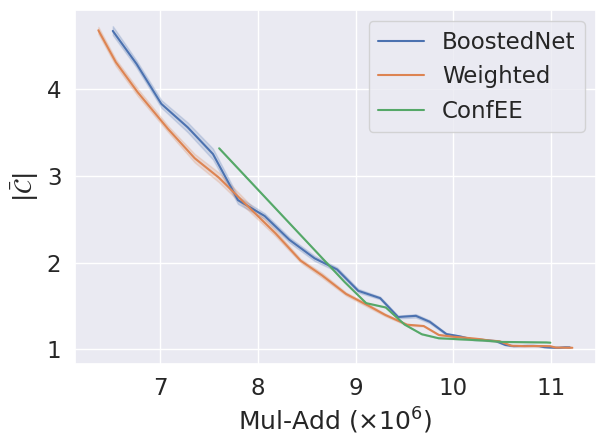

In [554]:
sns.set(font_scale=1.5)  # crazy big

sns.lineplot(data=filtered_boosted_df, x="average_IC", y="C", label="BoostedNet")
sns.lineplot(data=filtered_weighted_df, x="average_IC", y="C", label="Weighted")
sns.lineplot(data=filtered_our_df, x="average_IC", y="C", label="ConfEE")

plt.xlabel(r'Mul-Add ($\times 10^6$)')
plt.ylabel(r'$|\mathcal{\bar{C}}|$')
plt.tight_layout()
plt.savefig('inef_IC_'+dataset+'.pdf')


In [555]:

boosted_df_emp_vs_req = pd.DataFrame()
for cov_key in cov_keys_baseline:
    
    alpha = float(cov_key.split('cov_')[-1])
    df_cov = pd.DataFrame()
    df_cov['emp_alpha'] = 1-boosted_df[cov_key]/100.0
    df_cov['requested_alpha'] = alpha
    boosted_df_emp_vs_req = pd.concat([df_cov, boosted_df_emp_vs_req],axis=0, ignore_index=True)

weighted_df_emp_vs_req = pd.DataFrame()
for cov_key in cov_keys_baseline:
    
    alpha = float(cov_key.split('cov_')[-1])
    df_cov = pd.DataFrame()
    df_cov['emp_alpha'] = 1-weighted_df[cov_key]/100.0
    df_cov['requested_alpha'] = alpha
    weighted_df_emp_vs_req = pd.concat([df_cov, weighted_df_emp_vs_req],axis=0, ignore_index=True)
    
our_df_emp_vs_req = pd.DataFrame()

cov_keys_gated = []
cov_keys_gen = []
for c in cov_keys:
    if 'gen' in c:
        cov_keys_gen.append(c)
    else:
        cov_keys_gated.append(c)
for cov_key in cov_keys_gated:
    
    alpha = float(cov_key.split('cov_')[-1])
    df_cov = pd.DataFrame()
    df_cov['emp_alpha'] = 1-our_df[cov_key]
    df_cov['requested_alpha'] = alpha
    our_df_emp_vs_req = pd.concat([df_cov, our_df_emp_vs_req],axis=0, ignore_index=True)
    

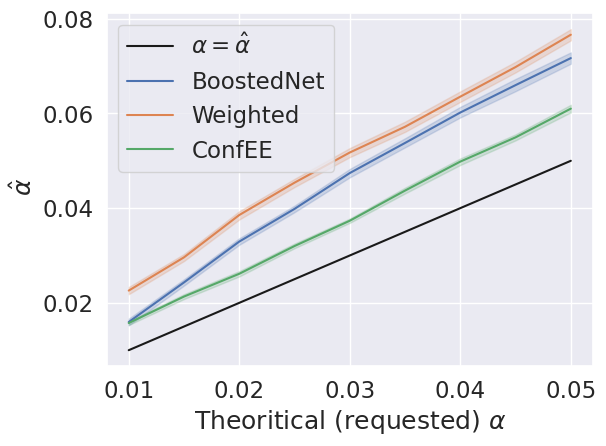

In [556]:
x = [0.01,0.05]
y = [0.01,0.05]
plt.plot(x,y, color='k',label=r'$\alpha = \hat{\alpha}$')
sns.lineplot(data=boosted_df_emp_vs_req, x="requested_alpha", y="emp_alpha", label="BoostedNet")
sns.lineplot(data=weighted_df_emp_vs_req, x="requested_alpha", y="emp_alpha", label="Weighted")
sns.lineplot(data=our_df_emp_vs_req, x="requested_alpha", y="emp_alpha", label="ConfEE")

plt.xlabel(r'Theoritical (requested) $\alpha$')
plt.ylabel(r' $\hat{\alpha}$')
plt.tight_layout()
plt.savefig('emp_vs_theoritical_'+dataset+'.pdf')


In [569]:
df_acc_ours = pd.DataFrame()
point = our_point_to_display
for l in range(L):
    
    all_acc = 'test/acc'+str(l)
    
    gated_acc = 'test/gated_acc_'+str(l)
    percent_exit = 'test/percent_exit'+str(l)
    if gated_acc in point and len(point[gated_acc]) == 10:

        df_acc = pd.DataFrame()
      
        df_acc['gated'] = point[gated_acc]
        df_acc['all'] = point[all_acc]
        df_acc['gate'] = l
        percent_exit = point[percent_exit]
       
        df_acc['fraction exit'] = np.mean([100*p for p in percent_exit])
        df_acc_ours = pd.concat([df_acc_ours, df_acc],axis=0, ignore_index=True)
            
df_acc_ours['method'] = 'ConFEE'

In [570]:
df_acc_boosted = pd.DataFrame()
metrics = boosted_points[0]
for l in range(L):
    all_acc = 'ALL_ACC_PER_GATE_'+str(l)
    gated_acc = 'GATED_ACC_PER_GATE_'+str(l)
    num_exit = 'EXIT_RATE_PER_GATE_'+str(l)
    if gated_acc in metrics:
        df_acc = pd.DataFrame()
        df_acc['gated'] = metrics[gated_acc]
        df_acc['all'] = metrics[all_acc]
        df_acc['gate'] = l
        df_acc['fraction exit'] = np.mean(metrics[num_exit])
        df_acc_boosted = pd.concat([df_acc_boosted, df_acc],axis=0, ignore_index=True)
            


In [571]:
df_acc_boosted['method'] = 'BoostedNet'
df_acc =  pd.concat([df_acc_boosted, df_acc_ours],axis=0, ignore_index=True)

In [572]:
df_acc[df_acc['method']=='ConFEE']


,gated,all,gate,fraction exit,method
70,99.191375,83.700000,3,37.877738,ConFEE
71,98.684211,83.400000,3,37.877738,ConFEE
72,98.775153,83.600000,3,37.877738,ConFEE
73,98.492792,83.100000,3,37.877738,ConFEE
74,98.496630,83.200000,3,37.877738,ConFEE
75,98.512686,83.366667,3,37.877738,ConFEE
76,98.593691,83.385714,3,37.877738,ConFEE
77,98.612029,83.525000,3,37.877738,ConFEE
78,98.728187,83.755556,3,37.877738,ConFEE
79,98.676198,83.700000,3,37.877738,ConFEE


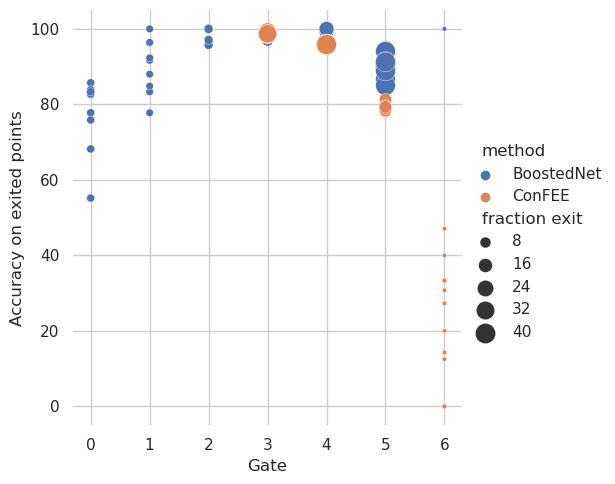

In [573]:
# sns.lineplot(data=df_acc_boosted, x="gate", y="all", label="Boosted")
# sns.lineplot(data=df_acc_boosted, x="gate", y="gated", label="Boosted_gated")
# sns.lineplot(data=df_acc_ours, x="gate", y="all", label="ConfEE")
# sns.lineplot(data=df_acc_ours, x="gate", y="gated", label="ConfEE_gated")

import seaborn as sns
sns.set_theme(style="whitegrid")

# Load the example planets dataset
planets = sns.load_dataset("planets")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
# g = sns.relplot(
#     data=df_acc_ours,
#     x="gate", y="all", label="ConfEE", size="fraction exit",
#     palette=cmap, sizes=(10, 200))
g = sns.relplot(
    data=df_acc,
    x="gate", y="gated", hue='method', label="gated acc", size="fraction exit",
     sizes=(10, 200))
g.despine(left=True, bottom=True)
g.set(xlabel ="Gate", ylabel = "Accuracy on exited points")
plt.savefig(dataset+'gated_acc.pdf')

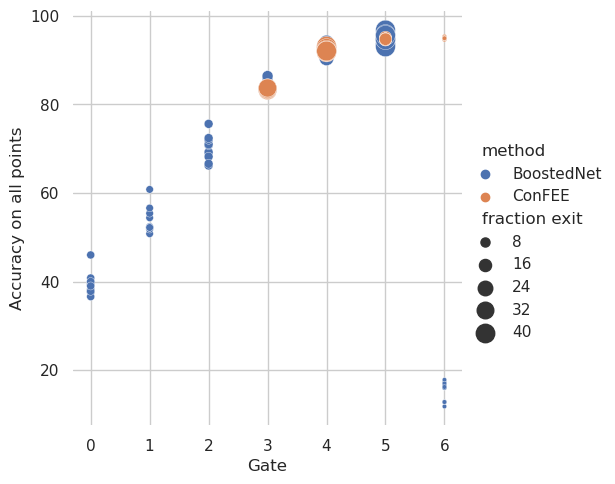

In [574]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Load the example planets dataset
planets = sns.load_dataset("planets")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
# g = sns.relplot(
#     data=df_acc_ours,
#     x="gate", y="all", label="ConfEE", size="fraction exit",
#     palette=cmap, sizes=(10, 200))
g = sns.relplot(
    data=df_acc,
    x="gate", y="all", hue='method', label="gated acc", size="fraction exit",
     sizes=(10, 200))
g.despine(left=True, bottom=True)
g.set(xlabel ="Gate", ylabel = "Accuracy on all points")
plt.savefig(dataset+'all_acc.pdf')